# MLP3 with Grey Wolf Optimizer

### Importing Necessary Modules

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve
import random
import copy

### Dataset related operations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset=pd.read_csv("/content/drive/MyDrive/Neural Networks/weatherHistory.csv")
dataset

,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Apparent Temperature (C)
0,9.472222,0.89,14.1197,251,15.8263,1015.13,7.388889
1,9.355556,0.86,14.2646,259,15.8263,1015.63,7.227778
2,9.377778,0.89,3.9284,204,14.9569,1015.94,9.377778
3,8.288889,0.83,14.1036,269,15.8263,1016.41,5.944444
4,8.755556,0.83,11.0446,259,15.8263,1016.51,6.977778
...,...,...,...,...,...,...,...
96448,26.016667,0.43,10.9963,31,16.1000,1014.36,26.016667
96449,24.583333,0.48,10.0947,20,15.5526,1015.16,24.583333
96450,22.038889,0.56,8.9838,30,16.1000,1015.66,22.038889
96451,21.522222,0.60,10.5294,20,16.1000,1015.95,21.522222


In [ ]:
df_scaled = preprocessing.scale(dataset)
df_scaled = pd.DataFrame(df_scaled, columns=dataset.columns)
df_scaled['target'] = dataset['Apparent Temperature (C)']
df_scaled.drop('Apparent Temperature (C)',axis=1,inplace=True)
df = df_scaled
X = df.loc[:, df.columns != 'target']
y = df.loc[:, 'target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Initialization of Grey Wolves Population

In [ ]:
def initialization(num_searchagent, dim):
    Positions=np.zeros((num_searchagent, dim))
    for i in range(num_searchagent):
        for j in range(dim):
            Positions[i][j]=round(np.random.uniform(low=0,high=1))
    return Positions

### Feed Forward Network

In [ ]:
def feedForward(pos,X,y,inputdim,hNeurons):
  temp = inputdim * hNeurons
  pos = np.array(pos)
  w1 = pos[:temp].reshape(hNeurons, inputdim)
  w2 = pos[temp:(temp+hNeurons)].reshape(hNeurons, 1)
  temp+=hNeurons
  b1 = pos[temp:(temp+hNeurons)].reshape(hNeurons, 1)
  temp+=hNeurons
  b2 = pos[temp:]
  h1=Sigmoid(np.dot(w1,X.T.to_numpy())+b1)
  h2=np.dot(w2.T,h1)+b2
  h2 = h2.reshape(y.shape,)
  return round(np.abs(y - h2).sum()/np.abs(y.mean()-y).sum(), 6)

In [ ]:
def Sigmoid(X):
  return 1/(1+np.exp(-10*(X-0.5)))

### GWO Implementation

In [ ]:
def GWO(SearchAgents_no,Max_iter,ub,lb,Cost_fun,X,y):
  
  dim= (hNeurons*(X.shape[1] + 2)+1)

  Alpha_pos=np.zeros(dim)
  Alpha_score=np.inf
  
  Beta_pos=np.zeros(dim)
  Beta_score=np.inf
  
  Delta_pos=np.zeros(dim)
  Delta_score=np.inf
  
  Positions=initialization(SearchAgents_no,dim)
  # print(Positions)
  
  Convergence_curve=np.zeros(Max_iter)

  l=0
  
  while l<Max_iter:
      
      for i in range(0,SearchAgents_no):
          
          fitness=Cost_fun(Positions[i],X,y,X.shape[1],hNeurons)
          fitness = abs(fitness)

          if fitness<Alpha_score:
              Alpha_score=fitness
              Alpha_pos=Positions[i].copy()
              
          if ((fitness>Alpha_score) and (fitness<Beta_score)):
              Beta_score=fitness
              Beta_pos=Positions[i].copy()
              
          if (fitness>Alpha_score) and (fitness>Beta_score) and (fitness<Delta_score):
              Delta_score=fitness
              Delta_pos=Positions[i].copy()
              
      a=2-l*((2)/Max_iter)
       
      for i in range(0,SearchAgents_no):
          
          for j in range(len(Positions[0])):
              
              r1=random.random()
              r2=random.random()
              A1=2*a*r1-a
              C1=2*r2
              D_alpha=abs(C1*Alpha_pos[j]-Positions[i][j])
            
                              
              r1=random.random()
              r2=random.random()
              A2=2*a*r1-a
              C2=2*r2
              D_beta=abs(C2*Beta_pos[j]-Positions[i][j])
              
              
              r1=random.random()
              r2=random.random()
              A3=2*a*r1-a
              C3=2*r2
              D_delta=abs(C3*Delta_pos[j]-Positions[i][j])


              X1=Alpha_pos[j] - A1*D_alpha
              X2=Beta_pos[j] - A2*D_beta              
              X3=Delta_pos[j] - A3*D_delta
              
              Positions[i][j]= (X1 + X2 + X3)/3
      Convergence_curve[l]=abs(Alpha_score)
      l+=1
      print('Iteration',l,'--',Alpha_score)
  return Alpha_score, Alpha_pos, Convergence_curve

### Testing Network

In [ ]:
def testForward(pos,X,y,inputdim,hNeurons):
  temp = inputdim * hNeurons
  pos = np.array(pos)
  w1 = pos[:temp].reshape(hNeurons, inputdim)
  w2 = pos[temp:(temp+hNeurons)].reshape(hNeurons, 1)
  temp+=hNeurons
  b1 = pos[temp:(temp+hNeurons)].reshape(hNeurons, 1)
  temp+=hNeurons
  b2 = pos[temp:]
  h1=Sigmoid(np.dot(w1,X.T.to_numpy())+b1)
  h2=np.dot(w2.T,h1)+b2
  h2 = h2.reshape(y.shape,)
  dfT = pd.DataFrame(data=h2, columns=['predicted'])
  dfT['Actual'] = y_test.values
  dfT.iloc[0:100].plot()
  print("Testing Error: ", np.abs(y_test - h2).sum()/np.abs(y_test.mean()-y_test).sum())


### Running the ANN with GWO

In [ ]:
Agents=100
MaxIter=50
ub=10
lb=-10
hNeurons = 13
fitness = feedForward
A, B, C = GWO(Agents,MaxIter,ub,lb,fitness,X_train,y_train)
print("Testing Error: ",feedForward(B,X_test,y_test,X_test.shape[1],hNeurons))

Iteration 1 -- 0.954493
Iteration 2 -- 0.810216
Iteration 3 -- 0.70979
Iteration 4 -- 0.63158
Iteration 5 -- 0.527736
Iteration 6 -- 0.399771
Iteration 7 -- 0.399104
Iteration 8 -- 0.372232
Iteration 9 -- 0.363175
Iteration 10 -- 0.344982
Iteration 11 -- 0.336376
Iteration 12 -- 0.312401
Iteration 13 -- 0.312401
Iteration 14 -- 0.279403
Iteration 15 -- 0.279403
Iteration 16 -- 0.279403
Iteration 17 -- 0.279403
Iteration 18 -- 0.279403
Iteration 19 -- 0.279403
Iteration 20 -- 0.279403
Iteration 21 -- 0.279403
Iteration 22 -- 0.279403
Iteration 23 -- 0.279403
Iteration 24 -- 0.279275
Iteration 25 -- 0.279275
Iteration 26 -- 0.277583
Iteration 27 -- 0.272327
Iteration 28 -- 0.272327
Iteration 29 -- 0.272327
Iteration 30 -- 0.265954
Iteration 31 -- 0.264926
Iteration 32 -- 0.257143
Iteration 33 -- 0.250346
Iteration 34 -- 0.249064
Iteration 35 -- 0.248883
Iteration 36 -- 0.246894
Iteration 37 -- 0.244717
Iteration 38 -- 0.239209
Iteration 39 -- 0.237183
Iteration 40 -- 0.234858
Iteration 4

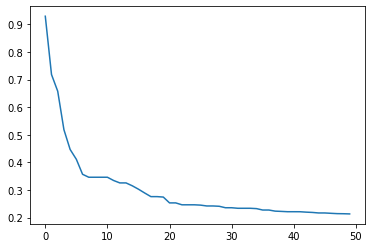

In [ ]:
plt.plot(C)
plt.show()

Testing Error:  0.21883495284840385


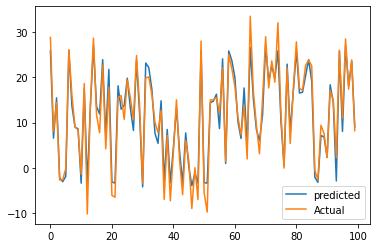

In [ ]:
testForward(B,X_test,y_test,6,hNeurons)

### [Documentation of Algorithm ](https://docs.google.com/document/d/1hTSRVxTti-p8kWtxuSM6xWA8bs89OGC5apciLqtO55g/edit?usp=sharing)